# DIOMIRA

Leaving there and proceeding for three days toward the east, you reach Diomira, a city with sixty silver domes, bronze statues of all the gods, streets paved with lead, a crystal theater, a golden cock that crows every morning on a tower. All these beauties will already be familiar to the visitor, who has seen them also in other cities. But the special quality of this city for the man who arrives there on a September evening, when the days are growing shorter and the multicolored lamps are lighted all at once at the doors of the food stalls and from a terrace a woman's voice cries ooh!, is that he feels envy toward those who now believe they have once before lived an evening identical to this and who think they were happy, that time.

In [1]:
from __future__ import print_function

In [2]:
from IPython.display import Image

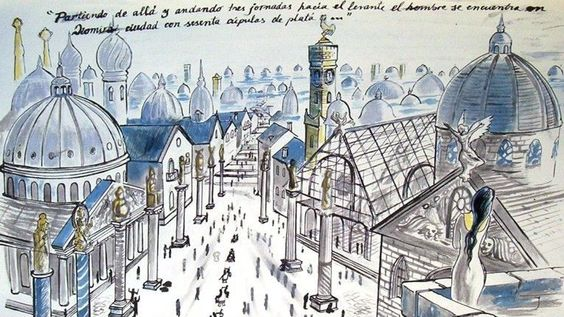

In [3]:
Image(filename='../../../Images/Diomira.jpg') 

In [4]:
%matplotlib inline

In [5]:
%load_ext autoreload

In [6]:
%autoreload 2

In [7]:
import logging
import sys
logger = logging.getLogger()
#logger.handlers[0].stream = sys.stdout
logger.setLevel(logging.DEBUG)

In [8]:
from Util import *
from Configure import *
from Nh5 import *

In [9]:
import tables
from time import time 
import pandas as pd

In [10]:
import FEParam as FP
import SPE as SP
import FEE2 as FE

In [11]:
import mplFunctions as mpl
import wfmFunctions as wfm
import sensorFunctions as snf
import tblFunctions as tbl

In [12]:
import cProfile

In [13]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

In [14]:
import time

### Diomira NB revisited on:

In [15]:
print(time.strftime("%d/%m/%Y"))

20/10/2016


In [16]:
print(time.strftime("%H:%M:%S"))

14:31:18


## Notes on DIOMIRA

### Role of DIOMIRA

Like all cities in IC, DIOMIRA consumes data to produce some new data. Specifically, DIOMIRA reads an hdf5 file containing MCRD (Monte Carlo Raw Data) for both the energy plane PMTs and the tracking plane SiPMs. 

MCRD represents the true response of sensors (PMTs and SiPMs) in NEXT. Each sensor reacts to the impinging light (primary en EL scintillation) by producing photoelectrons. The true response of the PMTs is described as a train or waveform of single photoelectrons (spe) in time bins of 1 ns. The true response of the SiPMs is described as a train of spes in bins of 1 mus.

The difference in time binning is related with differences in the electronics for PMTs and SiPMs. In the case of PMTs the ouput from the sensor (a current) is passed by the front-end PMT electronics (FEE-PMT) which can be described as the combination of a low-pass filters (LPF) which shapes and amplifies the signals, and a high-pass filter, associated with decoupling capacitor. 

See:
https://github.com/jjgomezcadenas/IC/blob/master/LabTools/DSP_sandbox_VHB.ipynb
https://github.com/jjgomezcadenas/IC/blob/master/Notebooks/SIERPE/SIERPE.ipynb

In the case of the SiPMs, the electronics is simpler (integration each 1 mus). 

The main action of DIOMIRA, then, is to read MCRD waveforms, simulate the response of the energy and tracking plane and produce raw waveforms (RWF) as well as base-line restored waveforms (BRL).

For the energy plane, RWF are the convolution of the MCRD with the LPF and HPF. The resulting function shows a negative swing associated with the differentiation introduced by the HPF. BLR functions are the convolution of the MCRD with the LPF only and correspond to an ideal case in which the RWF can be perfectly deconvoluted (.eg, base line restored). BLR are useful to compare with corrected waveforms (CWF) calculated later in the chain (by ISIDORA), where a real deconvolution algorithm is applied. In both cases, noise and the effect of DAQ is included. 

For the tracking plane, RWF correspond to add a realistic simulation of noise to the SiPMs. 

### Format

1. Diomira saves pmtrwf, sipmrwf and pmtblr wf as Int16, since those arrays correspond to the DAQ output (thus, adc counts). Using Int16 one can express up to 2**16, eg:

In [17]:
2**16

65536

Which is plenty to express the waveforms. 

2. The simulation of the WF is carried out using float64 (pyhton default) but one must convert to int before storing the waveforms. Round errors are negligible compared with both the scale and the noise, but the side effect is that the WF have many zeros which are effectively supressed by the compressor, thus saving space. 

3. If the function is stored as float, the zeros are not exact (e.g, numbers fluctuate around zero without being zero) and the compressor is not effective.

4. The difference in size is up to two orders of magnitude.

5. The simulation of pmtrwf and sipmrwf takes about 3 second/event and about 4.5 second/event adding the PMTBLR.

6. The space in disk is 350 kb/event (without BLR wfm) and 500 kb/event with blr 

### Code

#### PEP

In [20]:
!pep8 ../../../Cities/DIOMIRA.py

In [21]:
!pyflakes ../../../Cities/DIOMIRA.py

In [52]:
# %load ../../../Cities/DIOMIRA.py
"""
DIOMIRA
JJGC August-October 2016
GML October 2016

What DIOMIRA does:
1) Reads a MCRD file containing MC waveforms for the 12 PMTs of the EP.
   Each waveform contains number of PEs in bins of 1 ns.
2) Convolves the PE waveform with the response of the FEE electronics.
3) Decimates the waveform, simulating the effect of the DAQ sampling
(25 ns bins)
4) Writes a RWF file with the new data and adds the FEE simulation parameters
as metadata
"""

from __future__ import print_function
import sys
from time import time
import numpy as np
import tables

import system_of_units as units
from LogConfig import logger
from Configure import configure, define_event_loop
from Nh5 import FEE, SENSOR_WF

import FEParam as FP
import SPE as SP
import FEE2 as FE
from scipy import signal as SGN

import wfmFunctions as wfm
import coreFunctions as cf
import tblFunctions as tbl
import sensorFunctions as snf

from coreFunctions import wait

from RandomSampling import NoiseSampler as SiPMsNoiseSampler
"""

DIOMIRA
ChangeLog:

26.9

Changed types of PMTRWF, SIPMRWF and PMTTWF to Float32 for
    (compatibility with ART/GATE)

Do not store EPMT and ESIPM (can be computed on the fly)

Change sign of pmtrwf to negative (as produced by the DAQ)

28.9 add cython

29.9 changed the way true waveforms are treated.
before: --> full waveform (in bins of 25 ns) in an EArray
now--> ZS waveform rebinned at 1 mus in a Table
(adavantages:) faster processing less space

01.10 moved loop definition to Configure.py and added index to TWF table

11.10 introduced SiPM noise. SiPMs' true waveforms stored under TWF group.
Some variables, classes and functions renamed for clarity.

12.10 ZS functions to store the SiPMs

13.10 Reutilization of functions and some duplicities removed.
      SiPMs' waveforms to be stored without ZS.

14.10 JJ: Store all waveforms as Int16 (and as adc counts)

17.10: JJ PEP8 compliant and pyflakes compliant
(adjust to PEP8 syntax, eliminate import* etc.)

18.10 GML, add soft cut to eliminate noise below 0.5 pes in sipm plane

19.10 JJ: write calibration constants to FEE table!

20.10: JJ, store BLR with positive signal and baseline subtracted

"""


def FEE_param_table(fee_table):
    """
    Stores the parameters of the EP FEE simulation
    """
    row = fee_table.row
    row['offset'] = FP.offset
    row['ceiling'] = FP.ceiling
    row['pmt_gain'] = FP.PMT_GAIN
    row['V_gain'] = FP.V_GAIN
    row['R'] = FP.R
    row['C12'] = FP.C12
    row['CR'], row['CB'] = calibration_constants_from_spe()
    row['AC'] = FP.AC
    row['time_step'] = FP.time_step
    row['time_daq'] = FP.time_DAQ
    row['freq_LPF'] = FP.freq_LPF
    row['freq_HPF'] = 1./(2*np.pi*FP.R*FP.C)
    row['LSB'] = FP.LSB
    row['volts_to_adc'] = FP.voltsToAdc/units.volt
    row['noise_fee_rms'] = FP.NOISE_FEE
    row['noise_adc'] = FP.NOISE_ADC

    row.append()


def simulate_sipm_response(event_number, sipmrd_, sipms_noise_sampler):
    """
    Add noise with the SiPMNoiseSampler class and return the noisy waveform.
    """
    return sipmrd_[event_number] + sipms_noise_sampler.Sample()


def simulate_pmt_response(event_number, pmtrd_, BLR, blr_mau=500):
    """
    input:
     1) extensible array pmtrd_ (events, sensors, waveform)
     2) event_number
     3) flag BLR indicating if "ideal baseline restored" (BLR) waveforms should
     be computed.

    returns:
    array of raw waveforms (RWF), obtained by convoluting pmtrd_ with the PMT
    front end electronics (LPF, HPF)
    array of BLR waveforms (only convolution with LPF)

    """

    RWF = []
    BLRX = []

    for j in range(pmtrd_.shape[1]):
        logger.debug("-->PMT number ={}".format(j))

        pmt = pmtrd_[event_number, j]  # waveform for event event_number, PMT j
        fee = FE.FEE(PMTG=FP.PMT_GAIN, C=FP.C12[j], R=FP.R, f=FP.freq_LPF,
                     RG=FP.V_GAIN)  # instantiate FEE class
        # instantiate single photoelectron class
        spe = SP.SPE(pmt_gain=FP.PMT_GAIN, x_slope=5*units.ns,
                     x_flat=1*units.ns)

        # waveform "pmt" is passed to spe, output is a signal current
        signal_PMT = spe.SpePulseFromVectorPE(pmt)  # PMT response
        # Front end response to PMT pulse (in volts)
        signal_fee, signal_blr = fee.FEESignal(signal_PMT,
                                               noise_rms=FP.NOISE_FEE)
        # daq response (decimation)
        signal_daq = FP.offset - fee.daqSignal(signal_fee, noise_rms=0)
        signal_daq_blr = 0
        BASELINE = 0
        if BLR:
            signal_daq_blr = FP.ceiling - FP.offset + fee.\
                daqSignal(signal_blr, noise_rms=0)
            
            nm = blr_mau
            MAU = np.zeros(nm, dtype=np.double)
            B_MAU = (1./nm)*np.ones(nm, dtype=np.double)

            MAU[0:nm] = SGN.lfilter(B_MAU, 1, signal_daq_blr[0:nm])
            BASELINE = MAU[nm-1]
            
            #plt.plot(signal_daq_blr - BASELINE)
            #plt.show()
            #wait()

        RWF.append(signal_daq)
        BLRX.append(signal_daq_blr - BASELINE)

    return np.array(RWF), np.array(BLRX)


def calibration_constants_from_spe(start_pulse=100*units.ns,
                                   end_pulse=500*units.ns):
    """
    Computes calibration constants from the are of a SPE
    """
    spe = SP.SPE()
    cr = []
    cb = []

    for pmt, C in enumerate(FP.C12):
        fee = FE.FEE(PMTG=FP.PMT_GAIN, C=C, R=FP.R, f=FP.freq_LPF,
                     RG=FP.V_GAIN)
        # PMT response to a single photon (single pe current pulse)
        signal_t, signal_PE = spe.SpePulse(start_pulse, tmax=end_pulse)
        # effect of FEE
        signal_fee, signal_blr = fee.FEESignal(signal_PE,
                                               noise_rms=FP.NOISE_FEE)
        # effect of DAQ
        signal_daq = fee.daqSignal(signal_fee, noise_rms=0)
        signal_daq_blr = fee.daqSignal(signal_blr, noise_rms=0)
        area = np.sum(signal_daq)
        area_blr = np.sum(signal_daq_blr)
        print("PMT = {}: cc = {}, cc blr = {}".format(pmt, area, area_blr))
        cr.append(area)
        cb.append(area_blr)

    return cr, cb


def DIOMIRA(argv):
    """
    Diomira driver
    """
    DEBUG_LEVEL, INFO, CFP = configure(argv[0], argv[1:])

    if INFO:

        print("""
        DIOMIRA:
         1. Reads a MCRD file produced by art/centella, which stores MCRD
        waveforms for PMTs (bins of 1 ns) and SiPMs (bins of 1 mus)
        2. Simulates the response of the energy plane and outputs both RWF
        and TWF
        3. Simulates the response of the tracking plane in the SiPMs and
        outputs SiPM RWF
        4. Add a table describing the FEE parameters used for simulation
        5. Copies the tables on geometry, detector data and MC
        """)
        FP.print_FEE()

    PATH_IN = CFP['PATH_IN']
    PATH_OUT = CFP['PATH_OUT']
    FILE_IN = CFP['FILE_IN']
    FILE_OUT = CFP['FILE_OUT']
    PATH_DB = CFP['PATH_DB']
    FIRST_EVT = CFP['FIRST_EVT']
    LAST_EVT = CFP['LAST_EVT']
    RUN_ALL = CFP['RUN_ALL']
    CLIB = CFP['CLIB']
    CLEVEL = CFP['CLEVEL']
    BLR = CFP['BLR']
    NOISE_CUT = CFP['NOISE_CUT']
    NEVENTS = LAST_EVT - FIRST_EVT

    logger.info('Debug level = {}'.format(DEBUG_LEVEL))
    logger.info("""input path ={}; output path = {};
                   file_in ={} file_out ={}""".format(PATH_IN, PATH_OUT,
                                                      FILE_IN, FILE_OUT))

    logger.info("path to database = {}".format(PATH_DB))

    logger.info("""first event = {} last event = {}
                   nof events requested = {} """.format(FIRST_EVT, LAST_EVT,
                                                        NEVENTS))

    logger.info("Compression library = {} Compression level = {} ".format(CLIB,
                CLEVEL))

    logger.info("BLR simulation on(1)/off(0) = {}  ".format(BLR))
    logger.info("noise cut = {} pes ".format(NOISE_CUT))

    # open the input file
    with tables.open_file("{}/{}".format(PATH_IN, FILE_IN), "r") as h5in:
        # access the PMT raw data in file
        pmtrd_ = h5in.root.pmtrd
        sipmrd_ = h5in.root.sipmrd
        # pmtrd_.shape = (nof_events, nof_sensors, wf_length)

        NPMT = pmtrd_.shape[1]
        NSIPM = sipmrd_.shape[1]
        PMTWL = pmtrd_.shape[2]
        # PMTWL_FEE = int((PMTWL+1)/FP.time_DAQ) #old format
        PMTWL_FEE = int(PMTWL/FP.time_DAQ)
        SIPMWL = sipmrd_.shape[2]
        NEVENTS_DST = pmtrd_.shape[0]

        logger.info("""nof PMTs = {}
                       nof  SiPMs = {}
                       nof events in input DST = {} """.format(NPMT, NSIPM,
                                                               NEVENTS_DST))
        logger.info("""lof SiPM WF = {}
                       lof PMT WF (MC) = {}
                       lof PMT WF (FEE) = {}""".format(PMTWL, SIPMWL,
                                                       PMTWL_FEE))
        # access the geometry and the sensors metadata info
        geom_t = h5in.root.Detector.DetectorGeometry
        pmt_t = h5in.root.Sensors.DataPMT
        sipm_t = h5in.root.Sensors.DataSiPM
        mctrk_t = h5in.root.MC.MCTracks
        # pmtdf = snf.read_data_sensors(pmt_t)
        sipmdf = snf.read_data_sensors(sipm_t)

        # Create instance of the noise sampler
        sipms_noise_sampler_ = SiPMsNoiseSampler(PATH_DB+"/NoiseSiPM_NEW.dat",
                                                 sipmdf, SIPMWL, True)
        sipms_noise_thresholds_ = NOISE_CUT * np.array(sipmdf['adc_to_pes'])

        # open the output file
        with tables.\
                open_file("{}/{}".format(PATH_OUT, FILE_OUT), "w",
                          filters=tables.Filters(complib=CLIB,
                          complevel=CLEVEL)) as h5out:

            # create a group to store MC data
            mcgroup = h5out.create_group(h5out.root, "MC")
            # copy the mctrk table
            mctrk_t.copy(newparent=mcgroup)

            # create a group  to store geom data
            detgroup = h5out.create_group(h5out.root, "Detector")
            # copy the geom table
            geom_t.copy(newparent=detgroup)

            # create a group  store sensor data
            sgroup = h5out.create_group(h5out.root, "Sensors")
            # copy the pmt table
            pmt_t.copy(newparent=sgroup)
            # copy the sipm table
            sipm_t.copy(newparent=sgroup)

            # create a table to store Energy plane FEE, hang it from MC group
            fee_table = h5out.create_table(mcgroup, "FEE", FEE,
                                           "EP-FEE parameters",
                                           tables.Filters(0))

            # create a group to store True waveform data
            twfgroup = h5out.create_group(h5out.root, "TWF")
            # create a table to store true waveform (zs, rebinned)
            pmt_twf_table = h5out.\
                create_table(twfgroup, "PMT", SENSOR_WF, "Store for PMTs TWF",
                             tables.Filters(complib=CLIB, complevel=CLEVEL))

            sipm_twf_table = h5out.\
                create_table(twfgroup, "SiPM", SENSOR_WF, "Store for SiPM TWF",
                             tables.Filters(complib=CLIB, complevel=CLEVEL))

            # and index in event column
            pmt_twf_table.cols.event.create_index()
            sipm_twf_table.cols.event.create_index()

            # fill FEE table
            FEE_param_table(fee_table)

            # create a group to store RawData
            h5out.create_group(h5out.root, "RD")

            # create an extensible array to store the RWF waveforms
            pmtrwf = h5out.create_earray(h5out.root.RD, "pmtrwf",
                                         atom=tables.Int16Atom(),
                                         shape=(0, NPMT, PMTWL_FEE),
                                         expectedrows=NEVENTS_DST)
            pmtblr = 0
            if BLR:
                pmtblr = h5out.create_earray(h5out.root.RD, "pmtblr",
                                             atom=tables.Int16Atom(),
                                             shape=(0, NPMT, PMTWL_FEE),
                                             expectedrows=NEVENTS_DST)

            sipmrwf = h5out.create_earray(h5out.root.RD, "sipmrwf",
                                          atom=tables.Int16Atom(),
                                          shape=(0, NSIPM, SIPMWL),
                                          expectedrows=NEVENTS_DST)
            # LOOP
            first_evt, last_evt = define_event_loop(FIRST_EVT, LAST_EVT,
                                                    NEVENTS, NEVENTS_DST,
                                                    RUN_ALL)
            t0 = time()
            for i in range(first_evt, last_evt):
                logger.info("-->event number ={}".format(i))

                # supress zeros in MCRD and rebin the ZS function in 1 mus bins
                rebin = int(units.mus/units.ns)

                trueSiPM = wfm.sensor_wise_zero_suppression(sipmrd_[i], 0.)

                # dict_map applies a function to the dictionary values
                truePMT = cf.\
                    dict_map(lambda df: wfm.rebin_df(df, rebin),
                             wfm.sensor_wise_zero_suppression(pmtrd_[i],
                             0., to_mus=int(units.ns/units.ms)))

                # store in table
                tbl.store_wf(i, pmt_twf_table, truePMT)
                tbl.store_wf(i, sipm_twf_table, trueSiPM)

                # simulate PMT response and return an array with RWF;BLR
                # convert to float, append to EVector

                dataPMT, blrPMT = simulate_pmt_response(i, pmtrd_, BLR)
                pmtrwf.append(dataPMT.astype(int).reshape(1, NPMT, PMTWL_FEE))

                if BLR:
                    pmtblr.append(blrPMT.astype(int).reshape(1,
                                                             NPMT,
                                                             PMTWL_FEE))

                # simulate SiPM response and return an array with RWF
                # convert to float, zero suppress and dump to table
                dataSiPM = wfm.\
                    to_adc(simulate_sipm_response(i, sipmrd_,
                                                  sipms_noise_sampler_),
                           sipmdf)
                dataSiPM.astype(int)
                dataSiPM = wfm.\
                    noise_suppression(dataSiPM, sipms_noise_thresholds_)

                sipmrwf.append(dataSiPM.astype(int).reshape(1, NSIPM, SIPMWL))

            pmtrwf.flush()
            sipmrwf.flush()
            if BLR:
                pmtblr.flush()

            t1 = time()
            print("""DIOMIRA has run over {} events
                     in {} seconds""".format(i+1, t1-t0))
    print("Leaving Diomira. Safe travels!")

#if __name__ == '__main__':
    # import cProfile
    # cProfile.run('DIOMIRA(sys.argv)', sort='time')
    #DIOMIRA(sys.argv)


### Running DIOMIRA

In [213]:
ls -lh '/Users/jjgomezcadenas/Documents/Development/NEXT/data/test/nexus_NEW_NEXT_v0_08_00_Kr_ACTIVE_5bar_1000kev_0.next_10000.root.h5'

-rw-r--r--  1 jjgomezcadenas  staff   336M Sep 29 21:49 /Users/jjgomezcadenas/Documents/Development/NEXT/data/test/nexus_NEW_NEXT_v0_08_00_Kr_ACTIVE_5bar_1000kev_0.next_10000.root.h5


In [18]:
h5f =tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/data/test/nexus_NEW_NEXT_v0_08_00_Kr_ACTIVE_5bar_1000kev_0.next_10000.root.h5')

In [19]:
h5f

File(filename=/Users/jjgomezcadenas/Documents/Development/NEXT/data/test/nexus_NEW_NEXT_v0_08_00_Kr_ACTIVE_5bar_1000kev_0.next_10000.root.h5, title='', mode='r', root_uep='/', filters=Filters(complevel=0, shuffle=False, fletcher32=False, least_significant_digit=None))
/ (RootGroup) ''
/pmtrd (EArray(1000, 12, 1200000), zlib(1)) ''
  atom := Float32Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 1, 32768)
/sipmrd (EArray(1000, 1789, 1200), zlib(1)) ''
  atom := Float32Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 50, 1200)
/Detector (Group) ''
/Detector/DetectorGeometry (Table(1,)) ''
  description := {
  "x_det": Float32Col(shape=(2,), dflt=0.0, pos=0),
  "y_det": Float32Col(shape=(2,), dflt=0.0, pos=1),
  "z_det": Float32Col(shape=(2,), dflt=0.0, pos=2),
  "r_det": Float32Col(shape=(), dflt=0.0, pos=3)}
  byteorder := 'little'
  chunkshape := (2340,)
/MC (Group) ''
/MC/MCT

### Configuration file

In [441]:
%less ../../../Config/DIOMIRA_NA_ZLIB_test.csv

In [37]:
h5f.close()

In [66]:
DIOMIRA(['DIOMIRA','-d','INFO','-c''../../../Config/DIOMIRA_NA_ZLIB_test.csv'])

INFO:root:Debug level = INFO


Debug level = INFO


INFO:root:input path =/Users/jjgomezcadenas/Documents/Development/NEXT/data/test/; output path = /Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/;
                   file_in =nexus_NEW_NEXT_v0_08_00_Kr_ACTIVE_5bar_1000kev_0.next_10000.root.h5 file_out =Kr_5bar_10evt_sipmzs.h5


input path =/Users/jjgomezcadenas/Documents/Development/NEXT/data/test/; output path = /Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/;
                   file_in =nexus_NEW_NEXT_v0_08_00_Kr_ACTIVE_5bar_1000kev_0.next_10000.root.h5 file_out =Kr_5bar_10evt_sipmzs.h5


INFO:root:path to database = /Users/jjgomezcadenas/Documents/Development/NEXT/IC/Database


path to database = /Users/jjgomezcadenas/Documents/Development/NEXT/IC/Database


INFO:root:first event = 0 last event = 10
                   nof events requested = 10 


first event = 0 last event = 10
                   nof events requested = 10 


INFO:root:Compression library = zlib Compression level = 1 


Compression library = zlib Compression level = 1 


INFO:root:BLR simulation on(1)/off(0) = 1  


BLR simulation on(1)/off(0) = 1  


INFO:root:noise cut = 0.5 pes 


noise cut = 0.5 pes 


INFO:root:nof PMTs = 12
                       nof  SiPMs = 1789
                       nof events in input DST = 1000 


nof PMTs = 12
                       nof  SiPMs = 1789
                       nof events in input DST = 1000 


INFO:root:lof SiPM WF = 1200000
                       lof PMT WF (MC) = 1200
                       lof PMT WF (FEE) = 48000


lof SiPM WF = 1200000
                       lof PMT WF (MC) = 1200
                       lof PMT WF (FEE) = 48000


Initializing NoiseSampler... 1789
OK


HDF5ExtError: HDF5 error back trace

  File "H5F.c", line 522, in H5Fcreate
    unable to create file
  File "H5Fint.c", line 1024, in H5F_open
    unable to truncate a file which is already open

End of HDF5 error back trace

Unable to open/create file '/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns//Kr_5bar_10evt_sipmzs.h5'

In [54]:
h5f =tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/Kr_5bar_10evt_sipmzs.h5')

In [55]:
%ls -lh '/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/Kr_5bar_10evt_sipmzs.h5'

-rw-r--r--  1 jjgomezcadenas  staff   5.3M Oct 20 14:50 /Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/Kr_5bar_10evt_sipmzs.h5


#### About 540 kb/event

In [56]:
h5f

File(filename=/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/Kr_5bar_10evt_sipmzs.h5, title='', mode='r', root_uep='/', filters=Filters(complevel=1, complib='zlib', shuffle=True, fletcher32=False, least_significant_digit=None))
/ (RootGroup) ''
/Detector (Group) ''
/Detector/DetectorGeometry (Table(1,)) ''
  description := {
  "x_det": Float32Col(shape=(2,), dflt=0.0, pos=0),
  "y_det": Float32Col(shape=(2,), dflt=0.0, pos=1),
  "z_det": Float32Col(shape=(2,), dflt=0.0, pos=2),
  "r_det": Float32Col(shape=(), dflt=0.0, pos=3)}
  byteorder := 'little'
  chunkshape := (2340,)
/MC (Group) ''
/MC/FEE (Table(1,)) 'EP-FEE parameters'
  description := {
  "offset": Int16Col(shape=(), dflt=0, pos=0),
  "ceiling": Int16Col(shape=(), dflt=0, pos=1),
  "pmt_gain": Float32Col(shape=(), dflt=0.0, pos=2),
  "V_gain": Float32Col(shape=(), dflt=0.0, pos=3),
  "R": Float32Col(shape=(), dflt=0.0, pos=4),
  "time_step": Float32Col(shape=(), dflt=0.0, pos=5),
  "time_daq": Float32Col

In [57]:
pmttwf, sipmtwf, pmtrwf, pmtblr, sipmrwf, pmtdf, sipmdf, gdf, dFEE = tbl.get_vectors(h5f)

In [58]:
dFEE

{'fee_C_nF': C12    [3.76347e+16, 3.88563e+16, 3.78681e+16, 3.8832...
 dtype: object,
 'fee_accum': AC    [0.00165235, 0.00163149, 0.00163177, 0.0016294...
 dtype: object,
 'fee_adc_to_pes_blr': CB    [18.7451, 18.2045, 20.2066, 19.198, 18.6676, 1...
 dtype: object,
 'fee_adc_to_pes_raw': CR    [18.3083, 17.7813, 19.7725, 18.7745, 18.2494, ...
 dtype: object,
 'fee_param': offset           2.500000e+03
 ceiling          4.096000e+03
 pmt_gain         4.500000e+06
 V_gain           4.005443e-14
 R                3.765117e-13
 time_step        1.000000e+00
 time_daq         2.500000e+01
 freq_LPF         3.000000e-03
 freq_HPF         1.092347e-05
 LSB              4.882812e-10
 volts_to_adc     3.906250e-04
 noise_fee_rms    3.000000e-10
 noise_adc        7.680000e-01
 dtype: float64}

### Checking pmtrwf and pmtblr 

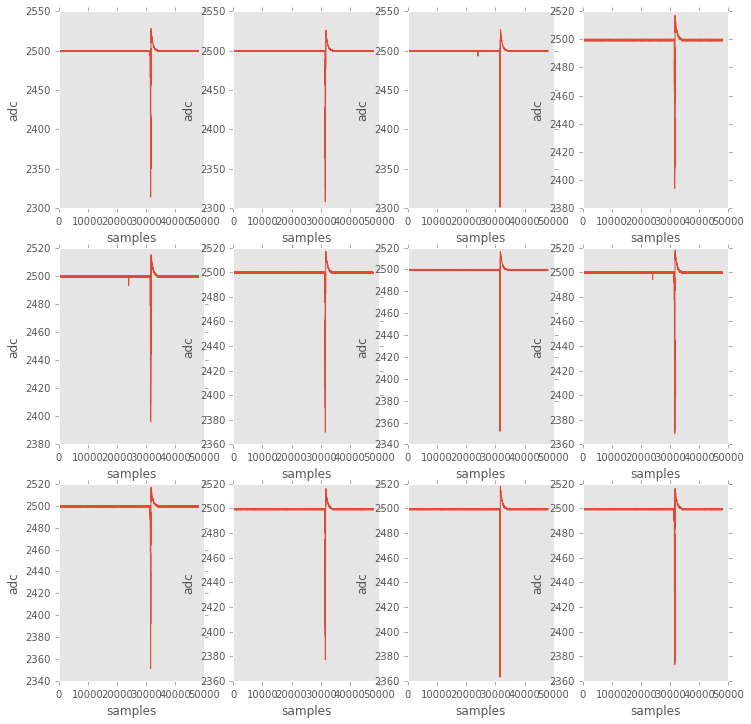

In [59]:
mpl.plot_waveforms(wfm.get_waveforms(pmtrwf,event_number=0))

In [60]:
pmtr0 = pmtrwf[0,0]

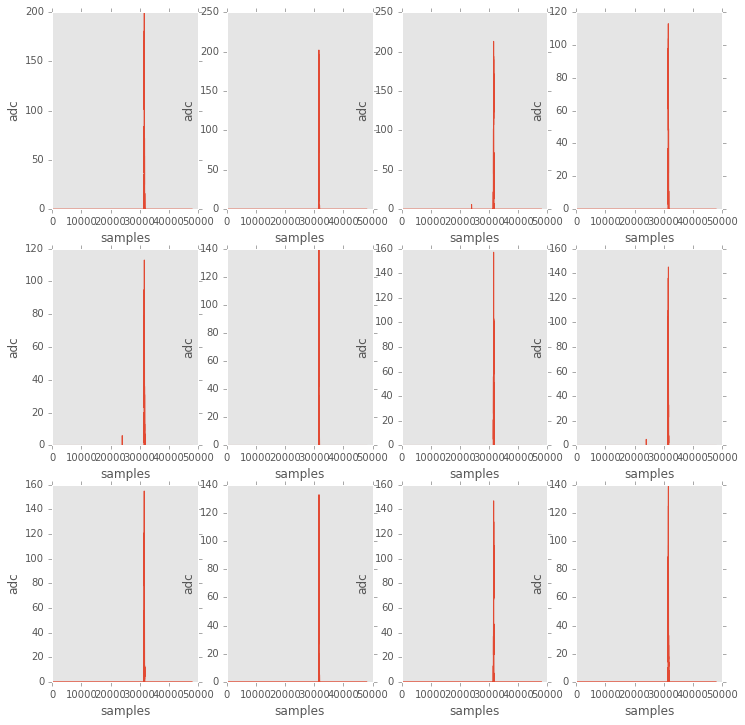

In [61]:
mpl.plot_waveforms(wfm.get_waveforms(pmtblr,event_number=0))

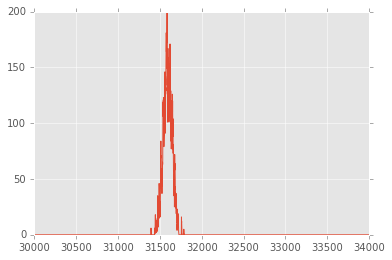

In [62]:
mpl.plts(pmtblr[0,0], signal_start=30000, signal_end=34000, offset=0)

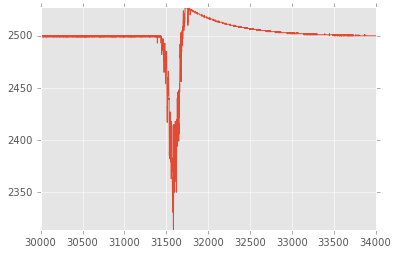

In [63]:
mpl.plts(pmtrwf[0,0], signal_start=30000, signal_end=34000, offset=0)

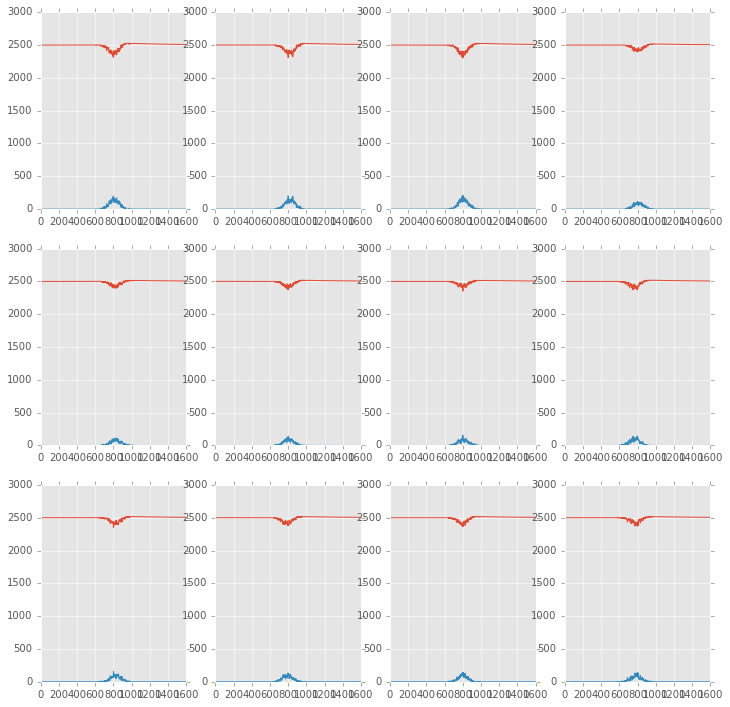

In [64]:
mpl.compare_raw_blr(pmtrwf, pmtblr, evt = 0, zoom = True, window_size = 800)

### True waveforms

In [26]:
pmttwf

/TWF/PMT (Table(120,), shuffle, zlib(1)) 'Store for PMTs TWF'
  description := {
  "event": UInt32Col(shape=(), dflt=0, pos=0),
  "ID": UInt32Col(shape=(), dflt=0, pos=1),
  "time_mus": Float32Col(shape=(), dflt=0.0, pos=2),
  "ene_pes": Float32Col(shape=(), dflt=0.0, pos=3)}
  byteorder := 'little'
  chunkshape := (4096,)
  autoindex := True
  colindexes := {
    "event": Index(6, medium, shuffle, zlib(1)).is_csi=False}

In [27]:
pmtp = tbl.read_wf_table(pmttwf, 0 )

works! We can access the data frames of the panel

In [28]:
pmtp

<class 'pandas.core.panel.Panel'>
Dimensions: 12 (items) x 1 (major_axis) x 2 (minor_axis)
Items axis: 0 to 11
Major_axis axis: 0 to 0
Minor_axis axis: ene_pes to time_mus

In [29]:
pmtp[11]

,ene_pes,time_mus
0,705.0,789782.6875


In [30]:
pmtp.items

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], dtype='int64')

In [31]:
pmtp[1]

,ene_pes,time_mus
0,1063.0,789637.0625


In [32]:
pmtp[1].sum().ene_pes

1063.0

In [33]:
def true_energy(sensorp):
    return sum(sensorp[i].ene_pes.values.sum() for i in sensorp.items)
    

In [38]:
def true_energy_distribution(pmttwf,event_list=range(10)):
    return np.array([true_energy(tbl.read_wf_table(pmttwf, event )) for event in event_list])
        

In [39]:
x = true_energy_distribution(pmttwf,event_list=range(10))


In [40]:
x

array([  9611.,   9137.,  10278.,   9602.,   9564.,   9669.,  10122.,
        10137.,   8096.,   8817.])

In [41]:
y = x[~np.isnan(x)]

In [42]:
y

array([  9611.,   9137.,  10278.,   9602.,   9564.,   9669.,  10122.,
        10137.,   8096.,   8817.])

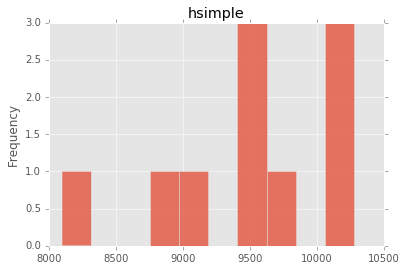

In [43]:
mpl.histo(y,10)

### SiPMs

In [83]:
def read_wf(table,event_number,isens):
    '''
        Reads table and returns the waveform (time_mus and ene_pes) corresponding
        to sensor isens of event event_number.
    '''
    try:
        return zip(*[ (row['time_mus'],row['ene_pes'])\
                     for row in table.iterrows() if row['event']== event_number and row['ID']== isens])
    except ValueError:
        logger.error('[read_wf]: empty sensor found: {}'.format(isens))


In [105]:
def wf2df(time_mus,energy_pes, dropnan=False):
    """
    takes two vectors (time, energy) and returns a data frame representing a waveform
    """
    if dropnan == False:
        return pd.DataFrame({'time_mus':time_mus,'ene_pes':energy_pes})
    else:
        return pd.DataFrame({'time_mus':time_mus,'ene_pes':energy_pes}).dropna()

In [114]:
def read_wf_table(table, event_number, dropnan=False):
    """
    Reads back the TWF of the PMTs/SiPMs for event number:
    input: the twf table of the PMTs,(SiPMs)  indexes and the event number
    outputs: a PMT/SiPM panel

    """
    sensor_list = set(table.read_where('event == {}'.format(event_number),field='ID'))
    print(sensor_list)
    wft = {}
    for isens in sensor_list:
        time, ene = read_wf(table,event_number,isens)
        df = wf2df(time, ene, dropnan=dropnan)
        print(df)
        wft[isens] = df.dropna()
    pdp = pd.Panel(wft)
    print(pdp[321])
    return pd.Panel(wft)


In [73]:
pmtp = read_wf_table( pmttwf, event_number=0 )

set([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])


In [74]:
pmtp[1]

,ene_pes,time_mus
0,1063.0,789637.0625


In [75]:
sipmp = read_wf_table(sipmtwf, event_number=0 )

set([321, 322, 323, 324, 325, 329, 330, 331, 332, 333, 337, 338, 339, 340, 341, 346, 347, 348, 349, 122, 123, 124])


In [76]:
sipmp

<class 'pandas.core.panel.Panel'>
Dimensions: 22 (items) x 10 (major_axis) x 2 (minor_axis)
Items axis: 122 to 349
Major_axis axis: 0 to 9
Minor_axis axis: ene_pes to time_mus

In [77]:
sipmp.items

Int64Index([122, 123, 124, 321, 322, 323, 324, 325, 329, 330, 331, 332, 333,
            337, 338, 339, 340, 341, 346, 347, 348, 349],
           dtype='int64')

In [78]:
sipmp[122]

,ene_pes,time_mus
0,0.570168,787.0
1,0.866632,790.0
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
5,NaN,NaN
6,NaN,NaN
7,NaN,NaN
8,NaN,NaN
9,NaN,NaN


In [120]:
sipmp = read_wf_table(sipmtwf, event_number=0, dropnan=True)

set([321, 322, 323, 324, 325, 329, 330, 331, 332, 333, 337, 338, 339, 340, 341, 346, 347, 348, 349, 122, 123, 124])
    ene_pes  time_mus
0  2.926629     790.0
1  1.016609     791.0
    ene_pes  time_mus
0  0.989625     786.0
1  5.134616     787.0
2  1.713405     788.0
3  5.171690     789.0
4  7.467691     790.0
5  0.102719     791.0
     ene_pes  time_mus
0   0.937262     784.0
1   1.830109     786.0
2  15.137391     787.0
3  39.573372     788.0
4  19.500580     789.0
5  41.112606     790.0
6  20.442823     791.0
     ene_pes  time_mus
0   0.441508     786.0
1   5.999704     787.0
2  17.022896     788.0
3  14.124597     789.0
4  11.871054     790.0
5   1.919034     791.0
    ene_pes  time_mus
0  2.474795     786.0
1  3.194513     788.0
2  3.215134     789.0
3  0.412925     792.0
    ene_pes  time_mus
0  1.032387     788.0
1  1.839522     789.0
2  1.790622     791.0
     ene_pes  time_mus
0   0.836310     785.0
1   3.896551     786.0
2   1.703345     787.0
3  12.231436     788.0
4  15.

In [121]:
z = sipmp[321]

In [122]:
z

,ene_pes,time_mus
0,2.926629,790.0
1,1.016609,791.0
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
5,NaN,NaN
6,NaN,NaN
7,NaN,NaN
8,NaN,NaN
9,NaN,NaN


In [131]:
def clean_na(panel):
    nd = {}
    for i in panel.items:
        nd[i] = sipmp[i].dropna()
    return nd
    

In [132]:
z = clean_na(sipmp)

In [134]:
z[122]

,ene_pes,time_mus
0,0.570168,787.0
1,0.866632,790.0


In [130]:
z[122]

,ene_pes,time_mus
0,0.570168,787.0
1,0.866632,790.0
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
5,NaN,NaN
6,NaN,NaN
7,NaN,NaN
8,NaN,NaN
9,NaN,NaN


In [44]:
sipmp = tbl.read_wf_table(sipmtwf, 0 )

In [45]:
sipmp.items

<class 'pandas.core.panel.Panel'>
Dimensions: 22 (items) x 10 (major_axis) x 2 (minor_axis)
Items axis: 122 to 349
Major_axis axis: 0 to 9
Minor_axis axis: ene_pes to time_mus

In [49]:
sipmp.items

Int64Index([122, 123, 124, 321, 322, 323, 324, 325, 329, 330, 331, 332, 333,
            337, 338, 339, 340, 341, 346, 347, 348, 349],
           dtype='int64')

In [53]:
sipmp[321]

,ene_pes,time_mus
0,2.926629,790.0
1,1.016609,791.0
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
5,NaN,NaN
6,NaN,NaN
7,NaN,NaN
8,NaN,NaN
9,NaN,NaN


In [46]:
x = true_energy_distribution(sipmtwf,event_list=range(10))

In [47]:
x

array([ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan])

In [ ]:
sipmrwfp = wfm.read_twf(sipmrwf, pmt_list, event_number=1)

In [ ]:
def plot_best(sipmrwf,sipmtwf,sipmdf, evt = 0):
    '''
        Plot the noisy waveform of the SiPM with greatest charge and superimpose the true waveform.
    '''
    #Find SiPM with greatest peak
    maxsipm = np.unravel_index(sipmrwf[evt,:,:].argmax(),sipmrwf[evt,:,:].shape)[0]
    print("SiPM with greatest peak is at index {} with ID {}".format(maxsipm,sipmdf.ix[maxsipm].channel))
    # Plot noisy waveform in red and noiseless waveform in blue
    true_times, true_amps = zip(*[ (row['time_mus'],row['ene_pes']) for row in sipmtwfm.iterrows() if row['event'] == evt and row['sipm'] == maxsipm ])
    plt.plot(sipmrwf[evt,maxsipm,:])
    plt.plot(true_times,true_amps)

In [64]:
pmtp = read_sensor_twf(pmttwf, pmt_list, event_number=9)

In [65]:
pmtp

<class 'pandas.core.panel.Panel'>
Dimensions: 12 (items) x 1 (major_axis) x 2 (minor_axis)
Items axis: 0 to 11
Major_axis axis: 0 to 0
Minor_axis axis: ene_pes to time_mus

In [66]:
pmtp[1]

,ene_pes,time_mus
0,942.0,1063.665283


But what i

In [ ]:
PMT={ ipmt : wfm.wf2df(zip(*[ (row['time_mus'],row['ene_pes']) for row in pmttwfm.iterrows() if row['event']== event_number and row['pmt']== ipmt])) for ipmt in pmt_list }
#
for ipmt in pmt_list:
    time_mus, ene_pes = zip(*[ (row['time_mus'],row['ene_pes']) for row in pmttwfm.iterrows() if row['event']== event_number and row['pmt']== ipmt])
                             
    PMT[i] = wfm.wf2df(time_mus,energy_pes)
                             
                        

In [40]:
import sensorFunctions as snf

In [41]:
def get_vectors(h5f):
    """
    input: file pointer
    returns: data vectors
    """
    pmtrwf = h5f.root.RD.pmtrwf
    sipmrwf = h5f.root.RD.sipmrwf
    geom_t = h5f.root.Detector.DetectorGeometry
    pmt_t = h5f.root.Sensors.DataPMT
    sipm_t = h5f.root.Sensors.DataSiPM
    gdf = snf.read_data_geom(geom_t)
    pmtdf = snf.read_data_sensors(pmt_t)
    sipmdf = snf.read_data_sensors(sipm_t)
    return pmtrwf,sipmrwf,pmtdf,sipmdf,gdf


In [43]:
pmtrwf,sipmrwf,pmtdf,sipmdf,gdf = get_vectors(h5f)

In [44]:
pmtdf

,active,adc_to_pes,channel,gain,x,y
0,1,-22.916800,0,0.001641,-23.941401,65.778503
1,1,-23.750999,1,0.001623,-44.995098,-53.623100
2,1,-25.300800,2,0.000000,68.936501,-12.155400
3,1,-25.998400,3,0.000000,-0.000000,185.000000
4,1,-23.707399,4,0.001596,-118.916000,141.718002
5,1,-20.892700,5,0.001581,-182.188995,32.124901
6,1,-22.134001,6,0.000000,-160.214996,-92.500000
7,1,-33.099300,7,0.000000,-63.273701,-173.843002
8,1,-20.437700,8,0.001622,63.273701,-173.843002
9,1,-25.169800,9,0.001601,160.214996,-92.500000


In [ ]:
plot_pmtwf(PMTWF)

In [80]:
sipmr = sipmrwf[0]

In [109]:
def ene_sipm(sipmrwf, event_list=[0]):
    SIPM =[]
    for event in event_list:
        sipmrw = sipmrwf[event]
        ESIPM = []
        for i in range(sipmrwf.shape[1]):
            sipmw = sipmrw[i]
            xsum = np.sum(sipmw)
            if xsum > 0:
                ESIPM.append(xsum)
        SIPM.append(np.max(np.array(ESIPM)))
    return SIPM
                    

In [114]:
esipm = ene_sipm(sipmrwf, event_list=range(1000))

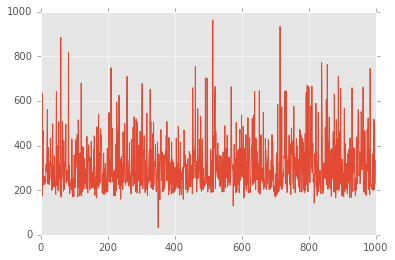

In [115]:
plt.plot(esipm)

In [116]:
np.average(esipm)

310.12219